In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from torch.utils.data import DataLoader, TensorDataset

In [2]:
training = np.load('training_inpainter_20240703.npz')

In [3]:
def parameter_tester(relu = "ReLU", pool = "MaxPool2d", dropout = 0.0, num_epochs = 90):
    class InpaintingAutoencoder(nn.Module):
        def __init__(self):
            super(InpaintingAutoencoder, self).__init__()
            
            relu_func = getattr(nn, relu)
            pool_func = getattr(nn, pool)

            # Encoder
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                relu_func(),
                pool_func(kernel_size=2, stride=2, padding=0),
                nn.Dropout(p=dropout),
                
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                relu_func(),
                pool_func(kernel_size=2, stride=2, padding=0),
                nn.Dropout(p=dropout),
                
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                relu_func()
            )
            
            # Decoder
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                relu_func(),
                nn.Dropout(p=dropout),
                
                nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                relu_func(),
                nn.Dropout(p=dropout),
                
                nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=0),
                relu_func()  # Use Sigmoid if images are normalized to [0, 1]
            )
        
        def forward(self, x):
            x = self.encoder(x)
            x = self.decoder(x)
            return x

    # Incomplete images (with holes)
    raw_incomplete = training['data']
    raw_incomplete_channels = np.expand_dims(raw_incomplete, axis=1)
    data_incomplete = np.repeat(raw_incomplete_channels, repeats=3, axis=1)  # Replace with actual data

    # Complete images (ground truth)
    raw_complete = training['complete']
    raw_complete_channels = np.expand_dims(raw_complete, axis=1)
    data_complete = np.repeat(raw_complete_channels, repeats=3, axis=1)

    # Masks
    raw_masks = training['source_masks']
    masks_channels = np.expand_dims(raw_masks, axis=1)
    masks = np.repeat(masks_channels, repeats=3, axis=1)
    #masks[masks != 0] = 1

    # Convert to PyTorch tensors
    data_incomplete = torch.tensor(data_incomplete, dtype=torch.float32)
    data_complete = torch.tensor(data_complete, dtype=torch.float32)


    # Split data into training and testing sets
    from sklearn.model_selection import train_test_split

    masks_train = masks[:700]
    masks_val = masks[700:850]
    masks_test = masks[850:]

    #X_train, X_test, y_train, y_test = train_test_split(data_incomplete, data_complete, test_size=0.2)

    X_train, X_temp, y_train, y_temp = train_test_split(data_incomplete, data_complete, test_size=0.3)

    # Split remaining data into validation (15%) and test (15%)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

    # Create DataLoaders
    batch_size = 32
    train_loader = DataLoader(TensorDataset(X_train, y_train, torch.tensor(masks_train)), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val, torch.tensor(masks_val)), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test, torch.tensor(masks_test)), batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = InpaintingAutoencoder()  
    criterion = nn.MSELoss(reduction='none')
    optimizer = optim.Adam(model.parameters(), lr=5e-4)

    start_time = time.time()

    losses_arr_cnn = []
    epochs_arr_cnn = []
    val_losses_arr_cnn = []

    # Training loop
    num_epochs = num_epochs
    for epoch in range(num_epochs):
        epochs_arr_cnn.append(epoch)
        model.train()
        running_loss = 0.0
        for incomplete, complete, masks in train_loader:
            #incomplete, complete = incomplete.cuda(), complete.cuda()
            
            optimizer.zero_grad()
            outputs = model(incomplete)
            
            loss = criterion(outputs, complete)
            loss = loss * masks.float()  # Compute loss only on the hole regions
            loss = loss.mean()
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        if ((epoch+1) % 10 == 0):
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Training time: {time.time() - start_time:.2f} seconds")
        losses_arr_cnn.append(epoch_loss)
        
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for incomplete, complete, masks in val_loader:
                val_outputs = model(incomplete)
                val_loss = criterion(val_outputs, complete)
                val_loss = val_loss * masks.float()  # Compute loss only on the hole regions
                val_loss = val_loss.mean()
        
        val_losses_arr_cnn.append(val_loss.item())

    training_time = time.time() - start_time
    print(f'Training time: {training_time:.2f} seconds')

    model.eval()
    with torch.no_grad():
        for images, targets, masks in test_loader:
            outputs = model(images)
            #plt.imshow(masks[0,0])
            # Combine reconstructed holes with the original incomplete image
            reconstructed = images * (~masks) + outputs * masks
            # Transpose the images to make them suitable for plt.imshow
            original_image = targets[0, 0].cpu().squeeze().numpy()
            incomplete_image = images[0, 0].cpu().squeeze().numpy()
            reconstructed_image = reconstructed[0, 0].cpu().squeeze().numpy()
            break

    for i in range(0, 8, 4):
        fig, axes = plt.subplots(1, 4, figsize=(12, 4))
        for j in range(0, 4):
            axes[j].imshow(reconstructed[i+j, 0])
            axes[j].set_title('Reconstructed Image')
            axes[j].axis('off')
        plt.show()

In [4]:
epoch_number = 90

Epoch 10/90, Loss: 0.0121, Training time: 47.39 seconds
Epoch 20/90, Loss: 0.0096, Training time: 95.18 seconds
Epoch 30/90, Loss: 0.0453, Training time: 143.02 seconds
Epoch 40/90, Loss: 0.0063, Training time: 191.37 seconds
Epoch 50/90, Loss: 0.0050, Training time: 239.65 seconds
Epoch 60/90, Loss: 0.0053, Training time: 287.66 seconds
Epoch 70/90, Loss: 0.0437, Training time: 335.79 seconds
Epoch 80/90, Loss: 0.0041, Training time: 383.67 seconds
Epoch 90/90, Loss: 0.0150, Training time: 431.85 seconds
Training time: 432.19 seconds


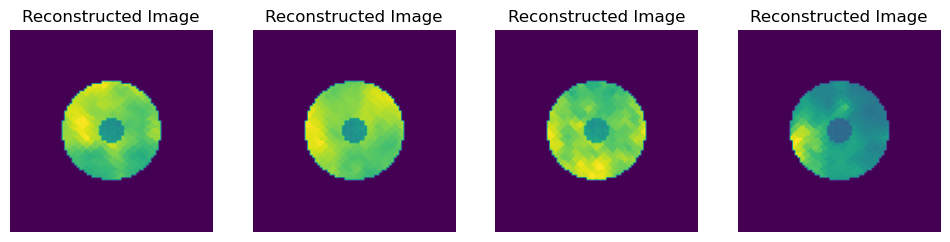

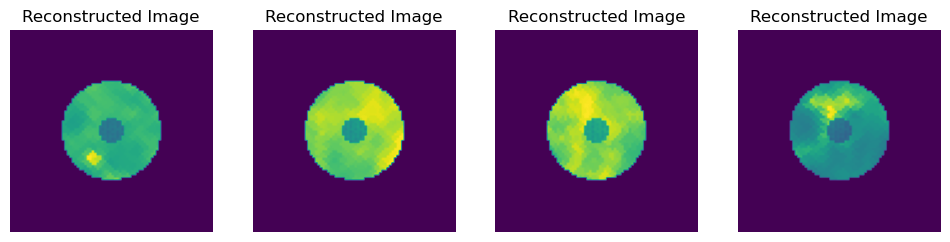

In [5]:
parameter_tester(relu="ReLU", pool="MaxPool2d", num_epochs=epoch_number)

Epoch 10/90, Loss: 0.0638, Training time: 47.14 seconds
Epoch 20/90, Loss: 0.0270, Training time: 94.68 seconds
Epoch 30/90, Loss: 0.4971, Training time: 141.85 seconds
Epoch 40/90, Loss: 0.0107, Training time: 189.07 seconds
Epoch 50/90, Loss: 0.0094, Training time: 236.61 seconds
Epoch 60/90, Loss: 0.0103, Training time: 284.30 seconds
Epoch 70/90, Loss: 0.0358, Training time: 333.58 seconds
Epoch 80/90, Loss: 0.0455, Training time: 383.86 seconds
Epoch 90/90, Loss: 0.0071, Training time: 432.80 seconds
Training time: 433.22 seconds


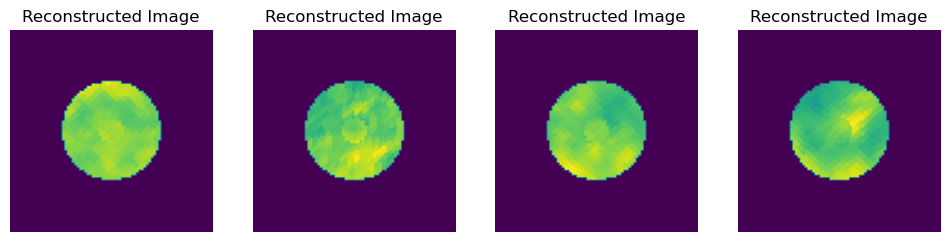

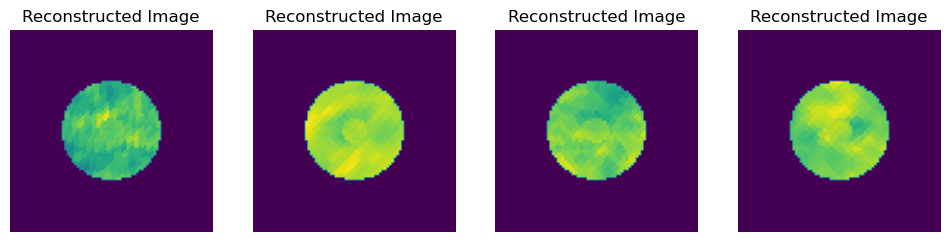

In [6]:
parameter_tester(relu="ReLU", pool="AvgPool2d", num_epochs=epoch_number)

Epoch 10/90, Loss: 0.0271, Training time: 59.26 seconds
Epoch 20/90, Loss: 0.0608, Training time: 119.97 seconds
Epoch 30/90, Loss: 0.0302, Training time: 179.89 seconds
Epoch 40/90, Loss: 0.0351, Training time: 240.03 seconds
Epoch 50/90, Loss: 0.0387, Training time: 300.18 seconds
Epoch 60/90, Loss: 0.0610, Training time: 360.40 seconds
Epoch 70/90, Loss: 0.0473, Training time: 422.03 seconds
Epoch 80/90, Loss: 0.0284, Training time: 482.31 seconds
Epoch 90/90, Loss: 0.0308, Training time: 542.75 seconds
Training time: 543.09 seconds


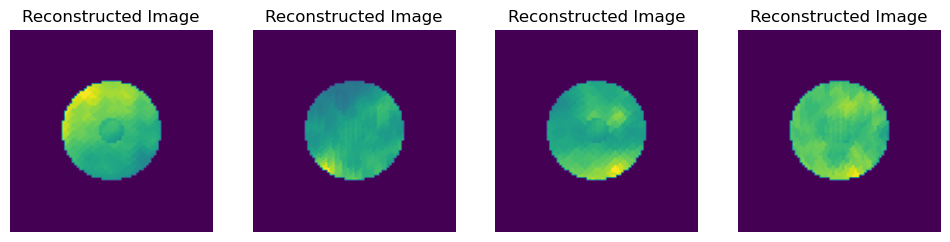

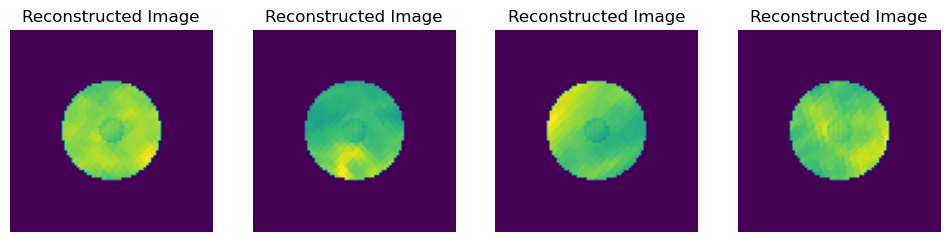

In [7]:
parameter_tester(relu="ReLU", pool="MaxPool2d", num_epochs=epoch_number, dropout=0.2)

Epoch 10/90, Loss: 0.0432, Training time: 59.56 seconds
Epoch 20/90, Loss: 0.0258, Training time: 119.22 seconds
Epoch 30/90, Loss: 0.0203, Training time: 179.13 seconds
Epoch 40/90, Loss: 0.0240, Training time: 239.12 seconds
Epoch 50/90, Loss: 0.0249, Training time: 299.34 seconds
Epoch 60/90, Loss: 0.0284, Training time: 359.92 seconds
Epoch 70/90, Loss: 0.0166, Training time: 420.57 seconds
Epoch 80/90, Loss: 0.0216, Training time: 480.55 seconds
Epoch 90/90, Loss: 0.0195, Training time: 540.46 seconds
Training time: 540.79 seconds


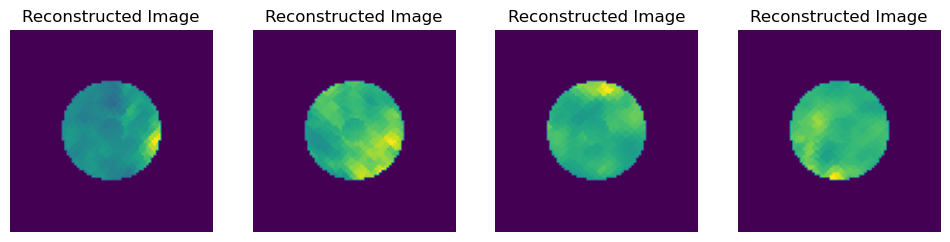

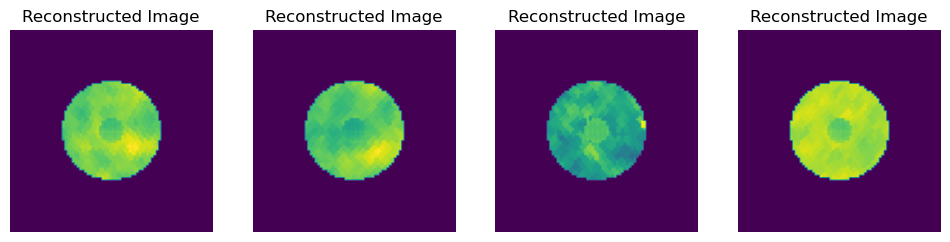

In [8]:
parameter_tester(relu="ReLU", pool="AvgPool2d", num_epochs=epoch_number, dropout=0.2)

Epoch 10/90, Loss: 0.0631, Training time: 45.55 seconds
Epoch 20/90, Loss: 0.0948, Training time: 92.19 seconds
Epoch 30/90, Loss: 0.0325, Training time: 138.29 seconds
Epoch 40/90, Loss: 0.0436, Training time: 184.36 seconds
Epoch 50/90, Loss: 0.0152, Training time: 230.46 seconds
Epoch 60/90, Loss: 0.0768, Training time: 276.66 seconds
Epoch 70/90, Loss: 0.0074, Training time: 322.93 seconds
Epoch 80/90, Loss: 0.0076, Training time: 369.40 seconds
Epoch 90/90, Loss: 0.0985, Training time: 415.48 seconds
Training time: 415.78 seconds


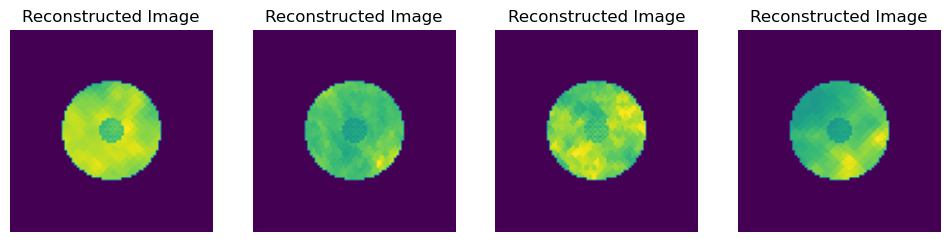

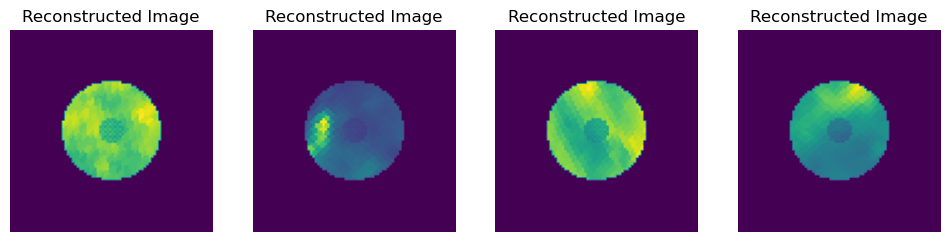

In [9]:
parameter_tester(relu="LeakyReLU", pool="MaxPool2d", num_epochs=epoch_number)

Epoch 10/90, Loss: 0.0119, Training time: 45.21 seconds
Epoch 20/90, Loss: 0.0129, Training time: 90.76 seconds
Epoch 30/90, Loss: 0.0258, Training time: 136.32 seconds
Epoch 40/90, Loss: 0.0076, Training time: 181.00 seconds
Epoch 50/90, Loss: 0.0057, Training time: 226.36 seconds
Epoch 60/90, Loss: 0.0048, Training time: 271.79 seconds
Epoch 70/90, Loss: 0.0043, Training time: 317.06 seconds
Epoch 80/90, Loss: 0.0472, Training time: 362.32 seconds
Epoch 90/90, Loss: 0.0035, Training time: 407.76 seconds
Training time: 408.14 seconds


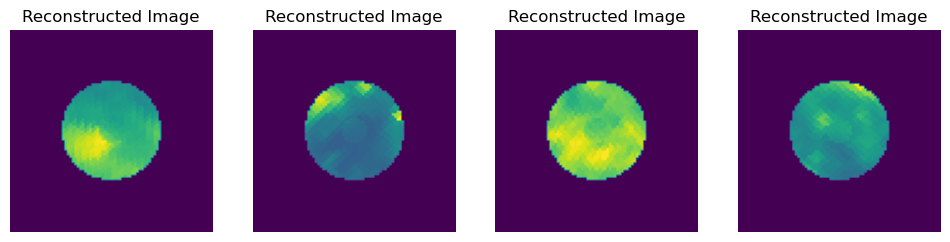

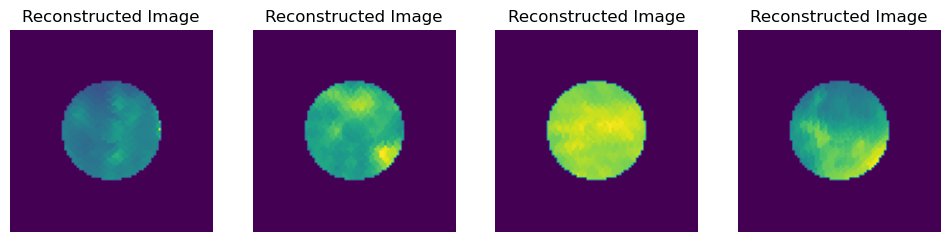

In [10]:
parameter_tester(relu="LeakyReLU", pool="AvgPool2d", num_epochs=epoch_number)

Epoch 10/90, Loss: 0.0741, Training time: 58.13 seconds
Epoch 20/90, Loss: 0.0218, Training time: 116.59 seconds
Epoch 30/90, Loss: 0.0246, Training time: 175.25 seconds
Epoch 40/90, Loss: 0.0186, Training time: 233.63 seconds
Epoch 50/90, Loss: 0.0154, Training time: 292.42 seconds
Epoch 60/90, Loss: 0.0158, Training time: 351.35 seconds
Epoch 70/90, Loss: 0.0148, Training time: 410.17 seconds
Epoch 80/90, Loss: 0.0182, Training time: 468.96 seconds
Epoch 90/90, Loss: 0.0205, Training time: 527.63 seconds
Training time: 527.94 seconds


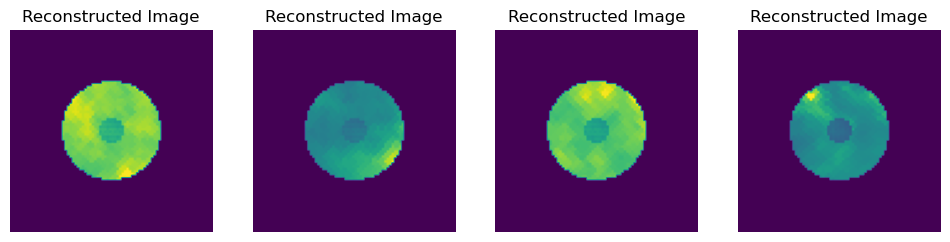

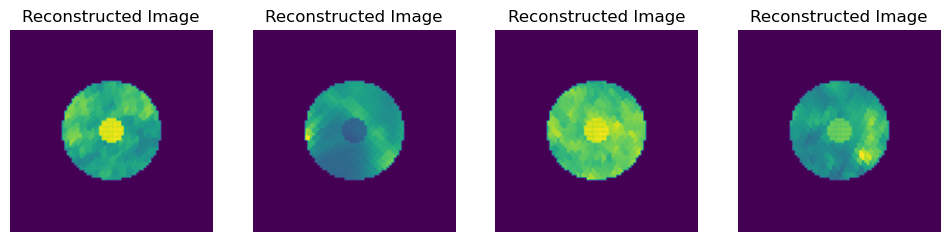

In [11]:
parameter_tester(relu="LeakyReLU", pool="MaxPool2d", num_epochs=epoch_number, dropout=0.2)

Epoch 10/90, Loss: 0.0330, Training time: 57.74 seconds
Epoch 20/90, Loss: 0.0293, Training time: 115.65 seconds
Epoch 30/90, Loss: 0.0461, Training time: 174.48 seconds
Epoch 40/90, Loss: 0.0226, Training time: 252.35 seconds
Epoch 50/90, Loss: 0.0236, Training time: 341.23 seconds
Epoch 60/90, Loss: 0.0319, Training time: 422.83 seconds
Epoch 70/90, Loss: 0.0205, Training time: 505.14 seconds
Epoch 80/90, Loss: 0.0195, Training time: 604.40 seconds
Epoch 90/90, Loss: 0.0227, Training time: 692.52 seconds
Training time: 693.15 seconds


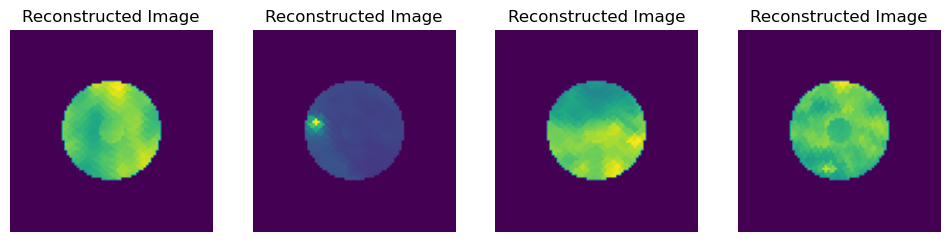

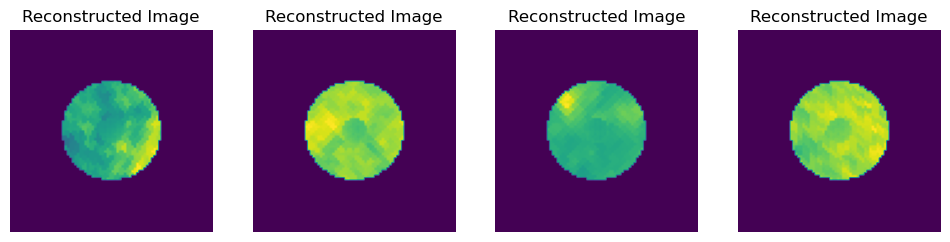

In [12]:
parameter_tester(relu="LeakyReLU", pool="AvgPool2d", num_epochs=epoch_number, dropout=0.2)

Epoch 10/90, Loss: 0.0888, Training time: 78.97 seconds
Epoch 20/90, Loss: 0.0115, Training time: 137.71 seconds
Epoch 30/90, Loss: 0.0108, Training time: 186.56 seconds
Epoch 40/90, Loss: 0.0135, Training time: 235.53 seconds
Epoch 50/90, Loss: 0.0076, Training time: 284.39 seconds
Epoch 60/90, Loss: 0.0702, Training time: 333.20 seconds
Epoch 70/90, Loss: 0.0068, Training time: 387.22 seconds
Epoch 80/90, Loss: 0.0043, Training time: 437.83 seconds
Epoch 90/90, Loss: 0.0097, Training time: 487.23 seconds
Training time: 487.62 seconds


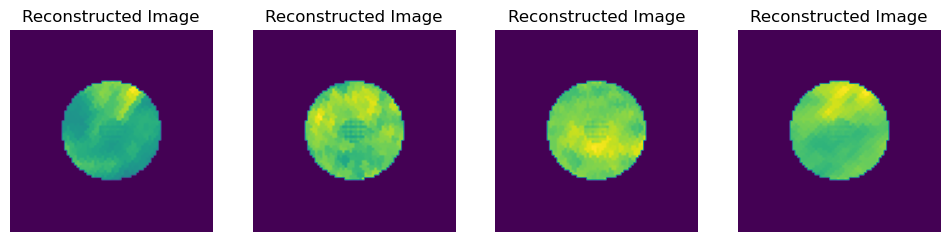

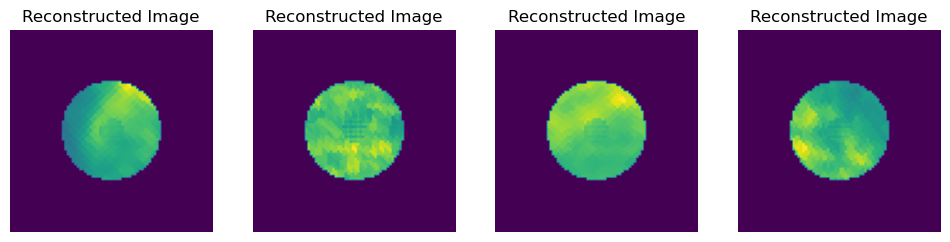

Epoch 10/90, Loss: 0.0109, Training time: 48.78 seconds
Epoch 20/90, Loss: 0.0321, Training time: 97.74 seconds
Epoch 30/90, Loss: 0.0071, Training time: 146.34 seconds
Epoch 40/90, Loss: 0.0067, Training time: 194.83 seconds
Epoch 50/90, Loss: 0.0164, Training time: 243.41 seconds
Epoch 60/90, Loss: 0.0547, Training time: 292.14 seconds
Epoch 70/90, Loss: 0.0378, Training time: 340.99 seconds
Epoch 80/90, Loss: 0.0044, Training time: 389.73 seconds
Epoch 90/90, Loss: 0.0178, Training time: 438.30 seconds
Training time: 438.65 seconds


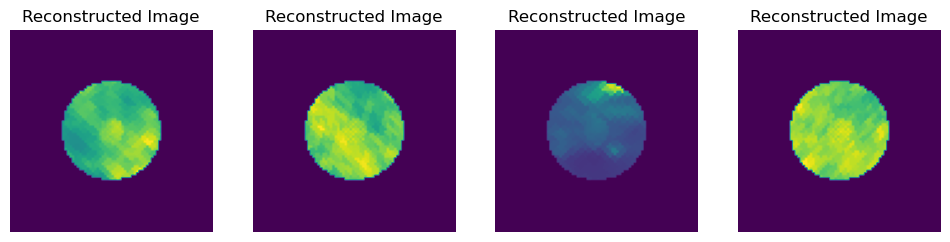

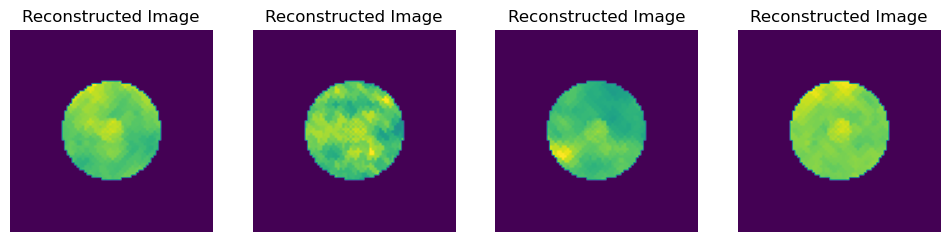

Epoch 10/90, Loss: 0.1434, Training time: 47.70 seconds
Epoch 20/90, Loss: 0.0164, Training time: 95.97 seconds
Epoch 30/90, Loss: 0.0492, Training time: 144.40 seconds
Epoch 40/90, Loss: 0.0187, Training time: 192.61 seconds
Epoch 50/90, Loss: 0.0290, Training time: 241.33 seconds
Epoch 60/90, Loss: 0.0123, Training time: 289.76 seconds
Epoch 70/90, Loss: 0.0068, Training time: 338.00 seconds
Epoch 80/90, Loss: 0.0075, Training time: 386.38 seconds
Epoch 90/90, Loss: 0.0055, Training time: 435.20 seconds
Training time: 435.57 seconds


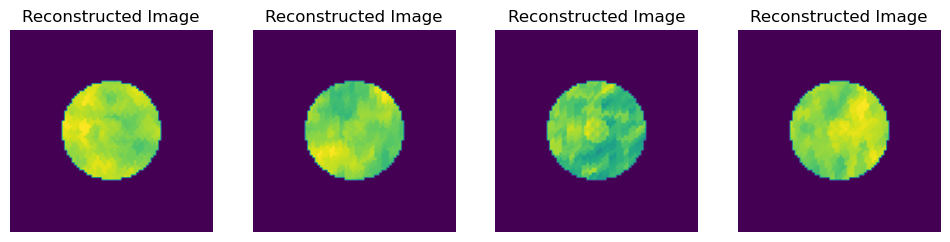

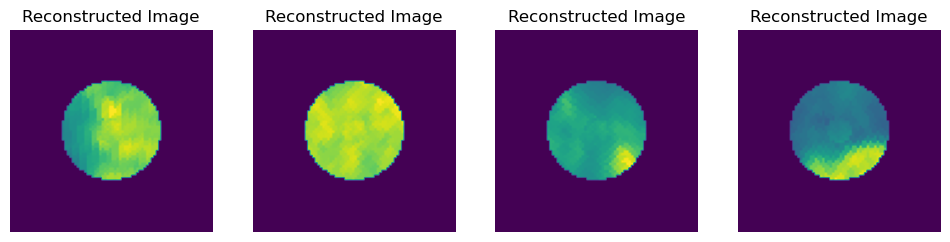

Epoch 10/90, Loss: 0.1601, Training time: 48.35 seconds
Epoch 20/90, Loss: 0.1550, Training time: 96.94 seconds
Epoch 30/90, Loss: 0.1554, Training time: 145.33 seconds
Epoch 40/90, Loss: 0.1589, Training time: 194.01 seconds
Epoch 50/90, Loss: 0.1488, Training time: 242.50 seconds
Epoch 60/90, Loss: 0.3738, Training time: 290.76 seconds
Epoch 70/90, Loss: 0.1483, Training time: 339.26 seconds
Epoch 80/90, Loss: 0.1461, Training time: 387.70 seconds
Epoch 90/90, Loss: 0.4667, Training time: 436.50 seconds
Training time: 436.92 seconds


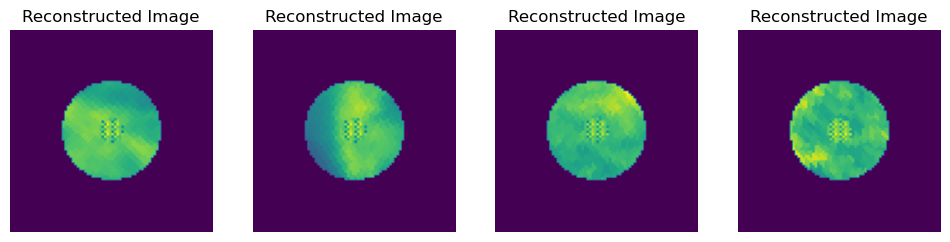

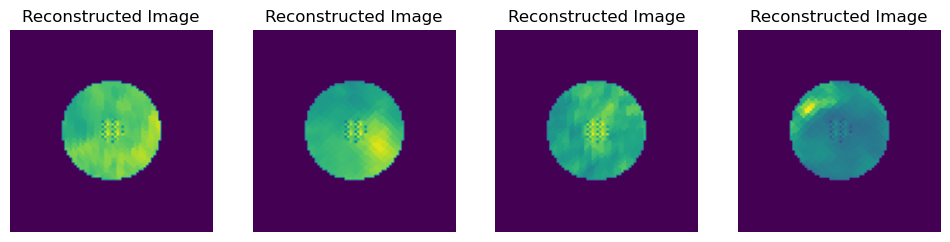

In [14]:
for i in range(4):
    parameter_tester(relu="ReLU", pool="MaxPool2d", num_epochs=epoch_number)